In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json


In [2]:
# Loading JSON file and performing preprocessing
import json
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
table = dict((ord(char), None) for char in string.punctuation)

file_name = "/kaggle/input/sarcasm-detection-through-nlp/Sarcasm_Headlines_Dataset.json"

# Opening JSON file
df = pd.read_json(file_name, lines = True)

headlines = []
labels = df['is_sarcastic']
    
# Preprocessing
for headline in df['headline']:
    headline = headline.lower()
    headline = headline.replace(".", " . ")
    headline = headline.replace(",", " , ")
    headline = headline.replace("-", " - ")
    headline = headline.replace("/", " / ")
    soup = BeautifulSoup(headline)
    headline = soup.get_text()
    headline = "".join([w.translate(table) for w in headline])
    headline = "".join([w for w in headline if w not in stop_words])
    headlines.append(headline)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_4206/1067204890.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(headline)


In [3]:
print(len(headlines))
print(len(labels))

26709
26709


In [4]:
# Creating train - test split
training_size = 20000

training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
# Tokenizing and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_tok = "<OOV>"

tk = Tokenizer(num_words = 20000, oov_token = oov_tok)
tk.fit_on_texts(training_headlines)
word_index = tk.word_index

training_sequences = tk.texts_to_sequences(training_headlines)

training_padded = pad_sequences(
    training_sequences,
    maxlen = 10,
    padding = 'post',
    truncating = 'post'
)

testing_sequences = tk.texts_to_sequences(testing_headlines)

testing_padded = pad_sequences(
    testing_sequences,
    maxlen = 10,
    padding = 'post',
    truncating = 'post'
)


2024-06-06 17:03:47.392549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 17:03:47.392635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 17:03:47.394269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
# here the adam learning rate is significantly reduced to prevent overfitting
# essentially it slows how much the model learns at each epoch

model = Sequential([
    Embedding(20000, 16), # 20 Thousand Words in Vocabulary to be trained, each word is
                          # represented by a 16x1 vector
    GlobalAveragePooling1D(), # Averages the dimensions
    Dense(24, activation = 'relu'),
    Dense(1, activation ='sigmoid')
])

model.compile(
    loss = "binary_crossentropy",
    optimizer = adam,
    metrics = ["accuracy"]
)

history = model.fit(
    training_padded, training_labels,
    epochs = 80,
    validation_data=(testing_padded, testing_labels) 
)

Epoch 1/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5600 - loss: 0.6873 - val_accuracy: 0.5634 - val_loss: 0.6701
Epoch 2/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5681 - loss: 0.6614 - val_accuracy: 0.6336 - val_loss: 0.6346
Epoch 3/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6792 - loss: 0.6203 - val_accuracy: 0.7035 - val_loss: 0.5965
Epoch 4/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7464 - loss: 0.5717 - val_accuracy: 0.7308 - val_loss: 0.5654
Epoch 5/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7728 - loss: 0.5343 - val_accuracy: 0.7465 - val_loss: 0.5409
Epoch 6/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7953 - loss: 0.4970 - val_accuracy: 0.7494 - val_loss: 0.5216
Epoch 7/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8037 - loss: 0.4709 - val_accuracy: 0.7559 - val_loss: 0.5076
Epoch 8/80
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8175 - loss: 0.4406 - val_accuracy: 0.

Maximum validation accuracy: 0.7713519334793091


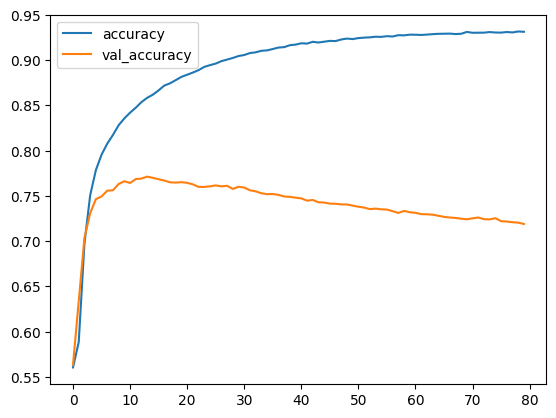

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

<Axes: >

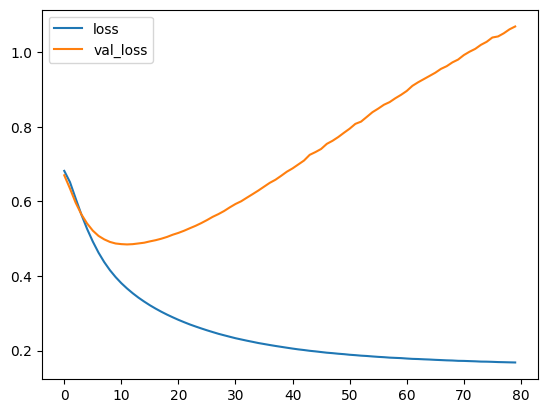

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()